In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


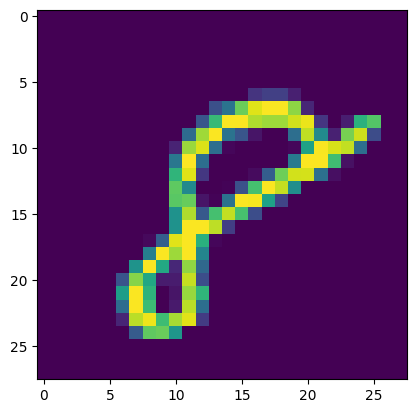

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

plt.imshow(x_train[-1])

In [ ]:
@keras.saving.register_keras_serializable()
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = num_clusters
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts] # (batch_size, H, W, C)
        # print("Expert outputs shape:", expert_outputs[0].shape)
        gate_output = self.gate(inputs) # (batch_size, num_experts)
        # print("Gate output shape:", gate_output.shape)
        weighted_expert_outputs = [
            tf.multiply(
                expert_output,
                tf.expand_dims(tf.expand_dims(tf.expand_dims(gate_output[:, i], axis=1), axis=1), axis=1)# (batch_size, 1, 1, 1)
            )
            for i, expert_output in enumerate(expert_outputs)
        ]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """U-Net-like autoencoder."""
        inputs = Input(shape=self.input_dim)

        # Encoder (Contracting Path)
        # Level 1
        c1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal")(inputs)
        c1 = BatchNormalization()(c1)
        c1 = Activation("relu")(c1)
        c1 = Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal")(c1)
        c1 = BatchNormalization()(c1)
        c1 = Activation("relu")(c1)
        p1 = MaxPooling2D((2, 2))(c1)  # Output: (14, 14, 32)

        # Level 2
        c2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(p1)
        c2 = BatchNormalization()(c2)
        c2 = Activation("relu")(c2)
        c2 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(c2)
        c2 = BatchNormalization()(c2)
        c2 = Activation("relu")(c2)
        p2 = MaxPooling2D((2, 2))(c2)  # Output: (7, 7, 64)

        # Level 3 (Bottom of the U-Net)
        c3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal")(p2)
        c3 = BatchNormalization()(c3)
        c3 = Activation("relu")(c3)
        c3 = Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal")(c3)
        c3 = BatchNormalization()(c3)
        c3 = Activation("relu")(c3)  # Output: (7, 7, 128)

        # Decoder (Expanding Path)
        # Level 2
        u2 = UpSampling2D((2, 2))(c3)  # Output: (14, 14, 128)
        u2 = Concatenate()([u2, c2])  # Skip connection from c2, Output: (14, 14, 192)
        c4 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(u2)
        c4 = BatchNormalization()(c4)
        c4 = Activation("relu")(c4)
        c4 = Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal")(c4)
        c4 = BatchNormalization()(c4)
        c4 = Activation("relu")(c4)  # Output: (14, 14, 64)

        # Level 1
        u1 = UpSampling2D((2, 2))(c4)  # Output: (28, 28, 64)
        u1 = Concatenate()([u1, c1])  # Skip connection from c1, Output: (28, 28, 96)
        c5 = Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal")(u1)
        c5 = BatchNormalization()(c5)
        c5 = Activation("relu")(c5)
        c5 = Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal")(c5)
        c5 = BatchNormalization()(c5)
        c5 = Activation("relu")(c5)  # Output: (28, 28, 32)

        # Output Layer
        outputs = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(c5)  # Output: (28, 28, 1)

        # Build Model
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        x = inputs
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        x = Dense(self.num_experts, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        return model

    def get_expert_outputs(self, x):
        return [expert(x) for expert in self.experts]

    def get_cluster_assignments(self, x):
        gating_weights = self.gate(x)
        return tf.argmax(gating_weights, axis=1)


input_dim = (28,28,1)
num_clusters = 10

model = MixtureOfExperts(input_dim, num_clusters)
model.compile(optimizer='adam', loss='mse')
# model.experts[0].summary()
model.summary()

Model: "mixture_of_experts_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_275 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_276 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_277 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_278 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_279 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_280 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_281 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_282 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_283 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_284 (Functional)          │ (None, 28, 28, 1)           │          57,611 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_285 (Functional)          │ (None, 10)                  │          25,258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601,368 (2.29 MB)

 Trainable params: 601,368 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test, x_test)
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 83ms/step - loss: 0.0710 - val_loss: 0.0240
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - loss: 0.0226 - val_loss: 0.0188
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 0.0185 - val_loss: 0.0173
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0169 - val_loss: 0.0164
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 12/50
469/469 ━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0114
Test MSE Loss: 0.011370645835995674


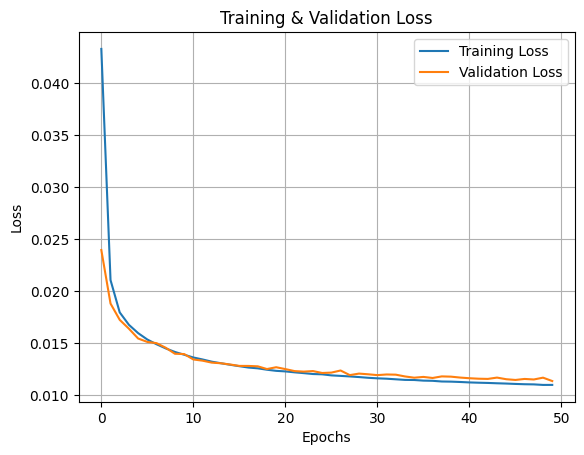

In [ ]:
print("Test MSE Loss:", model.evaluate(x_test, x_test))

# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
x_to_show = x_test[:10]
gating_weights = model.gate(x_to_show)
cluster_assignments = tf.argmax(gating_weights, axis=1)
expert_outputs = model.get_expert_outputs(x_to_show)
expert_outputs[0].shape

TensorShape([10, 28, 28, 1])

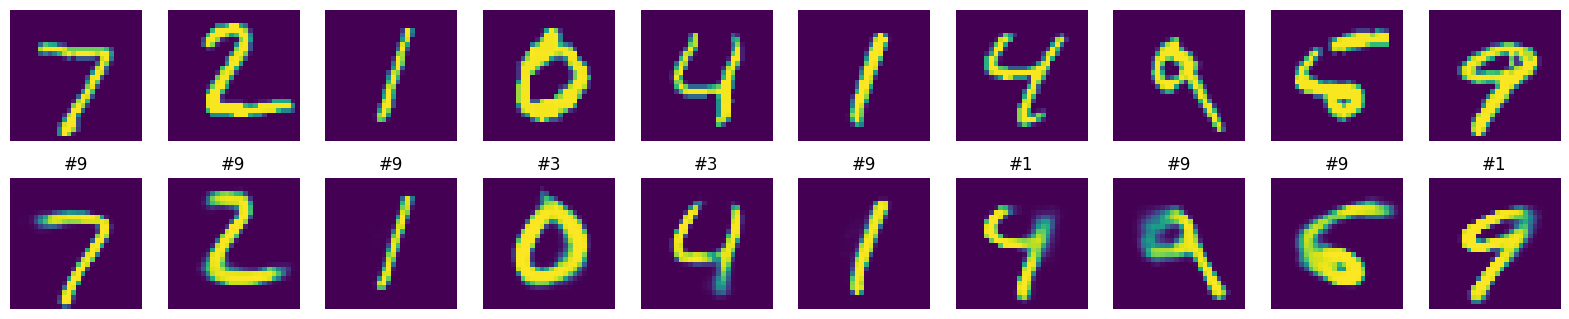

In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].squeeze())
    plt.axis('off')

    # Reconstructed image from assigned expert
    plt.subplot(2, 10, i + 11)
    plt.imshow(expert_outputs[cluster_assignments[i]][i].numpy().reshape(28, 28))
    plt.title(f"#{cluster_assignments[i]}")
    plt.axis('off')

plt.show()

In [ ]:
model.save("MoA_Conv_Auto_Conv_Gate.keras")